In [28]:
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import ta
import mplfinance as mpf
from itertools import product
import numpy as np

In [2]:
from src.DataUpdateModule import DataUpdateModule
DUM = DataUpdateModule()

In [3]:
df_stock, df_options = DUM.read_data(datetime(2022,1,7))

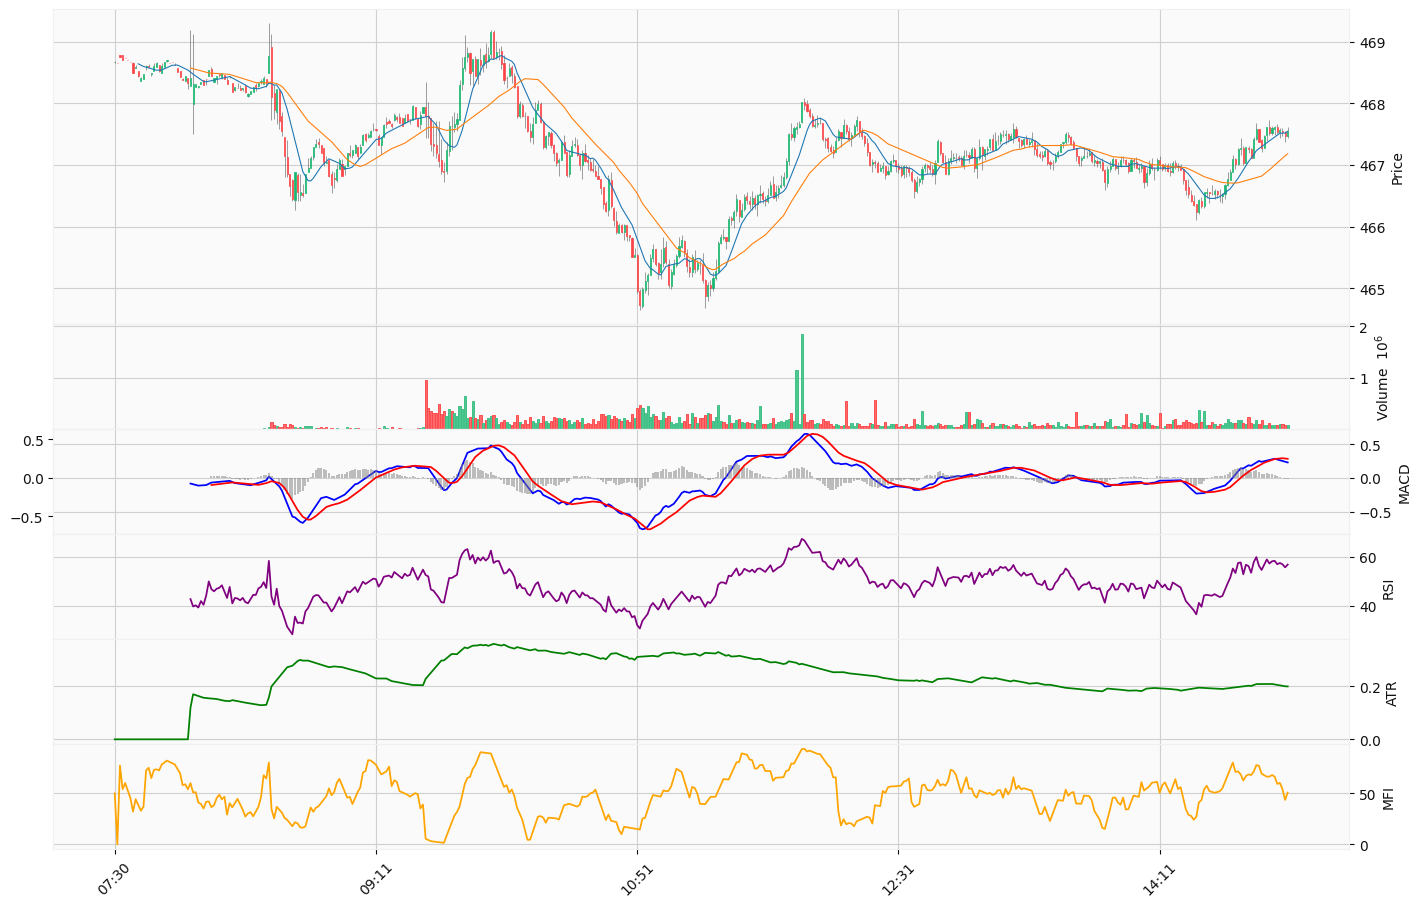

In [4]:
# Calculate indicators using ta package
df_stock['RSI'] = ta.momentum.RSIIndicator(df_stock['close'], window=30).rsi()
df_stock['MACD'] = ta.trend.MACD(df_stock['close'], window_fast=10, window_slow=30).macd()
df_stock['MACD_signal'] = ta.trend.MACD(df_stock['close'], window_fast=10, window_slow=30).macd_signal()
df_stock['MACD_diff'] = ta.trend.MACD(df_stock['close'], window_fast=10, window_slow=30).macd_diff()
df_stock['ATR'] = ta.volatility.AverageTrueRange(df_stock['high'], df_stock['low'], df_stock['close'], window=30).average_true_range()
df_stock['MFI'] = ta.volume.MFIIndicator(df_stock['high'], df_stock['low'], df_stock['close'], df_stock['volume'], window=14, fillna=True).money_flow_index()

# Create additional plots for indicators
apds = [
    mpf.make_addplot(df_stock['MACD'], panel=2, color='blue', ylabel='MACD'),
    mpf.make_addplot(df_stock['MACD_signal'], panel=2, color='red'),
    mpf.make_addplot(df_stock['MACD_diff'], panel=2, type='bar', color='gray', alpha=0.5),
    mpf.make_addplot(df_stock['RSI'], panel=3, color='purple', ylabel='RSI'),
    mpf.make_addplot(df_stock['ATR'], panel=4, color='green', ylabel='ATR'),
    mpf.make_addplot(df_stock['MFI'], panel=5, color='orange', ylabel='MFI'),
]

# Plot with all indicators
mpf.plot(
    df_stock, type="candle", mav=(10, 30), volume=True, 
    addplot=apds, style="yahoo", figsize=(18, 12),
    panel_ratios=(6,2,2,2,2,2)
)

# mpf.plot(df_stock, type = "candle", mav = (10, 30), volume = True, style = "yahoo", figsize = (18,8))

In [ ]:
params_grid = {
    "fast": [5, 10, 20], #sma|rsi|macd
    "slow_mult": [2, 3, 5], # sma|rsi|macd, for ATR also

    "rsi_threshold": [60, 70], #rsi only
}

tech_indicators = dict()
for params in product(*params_grid.values()):
    params = {list(params_grid.keys())[i] : params[i] for i in range(len(params))}

    fast = params['fast']
    slow = params['fast'] * params["slow_mult"]
    tech_indicators[f"sma_{fast}"] = ta.trend.SMAIndicator(df_stock['close'], window=fast).sma_indicator()
    tech_indicators[f"sma_{slow}"] = ta.trend.SMAIndicator(df_stock['close'], window=slow).sma_indicator()
    tech_indicators[f"rsi_{slow}"] = ta.momentum.RSIIndicator(df_stock['close'], window=slow).rsi()
    tech_indicators[f"macdsignal_{fast}_{slow}"] = ta.trend.MACD(df_stock['close'], window_fast=fast, window_slow=slow).macd_signal()
    tech_indicators[f"macddiff_{fast}_{slow}"] = ta.trend.MACD(df_stock['close'], window_fast=fast, window_slow=slow).macd_diff()
    tech_indicators[f"atr_{slow}"] = ta.volatility.AverageTrueRange(df_stock['high'], df_stock['low'], df_stock['close'], window=slow).average_true_range()

tech_indicators = pd.DataFrame(tech_indicators).dropna()

In [34]:
params = {
    "fast": 10,
    "slow_mult": 3,
    "rsi_threshold": 60
}

In [ ]:
enter_long = pd.Series(np.all([
    (tech_indicators[f"sma_{params['fast']}"] > tech_indicators[f"sma_{params['fast'] * params['slow_mult']}"]), # SMA_fast > SMA_slow
    (tech_indicators[f"macddiff_{params['fast']}_{params['fast'] * params['slow_mult']}"] > 0), # MACD diff > 0
    (tech_indicators[f"rsi_{params['fast'] * params['slow_mult']}"] <= params["rsi_threshold"]) # RSI not > 60
], axis = 0), index = tech_indicators.index)

exit_long = pd.Series(np.any([
    # RSI > 60
    tech_indicators[f"rsi_{params['fast'] * params['slow_mult']}"] > params["rsi_threshold"]
], axis = 0), index = tech_indicators.index)

In [44]:
enter_short = pd.Series(np.all([
    (tech_indicators[f"sma_{params['fast']}"] < tech_indicators[f"sma_{params['fast'] * params['slow_mult']}"]), # SMA_fast > SMA_slow
    (tech_indicators[f"macddiff_{params['fast']}_{params['fast'] * params['slow_mult']}"] < 0), # MACD diff > 0
    (tech_indicators[f"rsi_{params['fast'] * params['slow_mult']}"] >= 100 - params["rsi_threshold"]) # RSI not > 60
], axis = 0), index = tech_indicators.index)

exit_short = pd.Series(np.any([
    # RSI > 60
    tech_indicators[f"rsi_{params['fast'] * params['slow_mult']}"] < 100 - params["rsi_threshold"]
], axis = 0), index = tech_indicators.index)

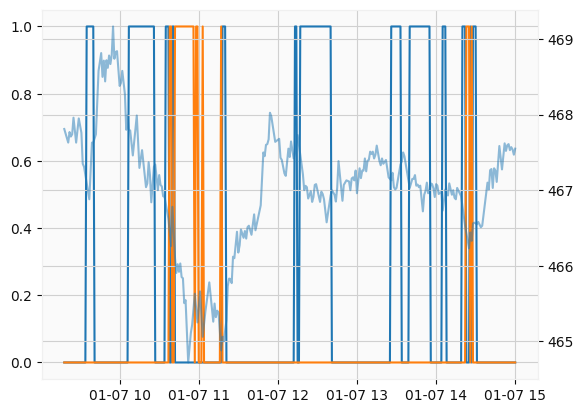

In [45]:
plt.plot(enter_short.astype(int), label='Enter short Signal')
plt.plot(exit_short.astype(int), label='Exit short Signal')
plt.twinx().plot(df_stock['close'].loc[tech_indicators.index], label='Close Price', alpha=0.5)

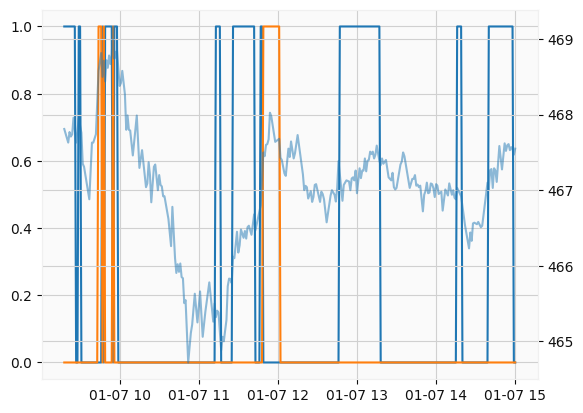

In [ ]:
plt.plot(enter_long.astype(int), label='Enter Long Signal')
plt.plot(exit_long.astype(int), label='Exit Long Signal')
plt.twinx().plot(df_stock['close'].loc[tech_indicators.index], label='Close Price', alpha=0.5)

In [53]:
class Strategy:
    def __init__(self):
        self.params_grid = {
            "fast": [5, 10, 20], #sma|rsi|macd
            "slow_mult": [2, 3, 5], # sma|rsi|macd, for ATR also
            "rsi_threshold": [60, 70], #rsi only
        }

        self.tech_indicators = None
        self.models = [{list(self.params_grid.keys())[i] : x[i] for i in range(len(x))} for x in list(product(*self.params_grid.values()))]

    def compute_tech_indicators(self, df_stock, ret = False):
        tech_indicators = dict()
        for params in product(*self.params_grid.values()):
            params = {list(self.params_grid.keys())[i] : params[i] for i in range(len(params))}

            fast = params['fast']
            slow = params['fast'] * params["slow_mult"]
            tech_indicators[f"sma_{fast}"] = ta.trend.SMAIndicator(df_stock['close'], window=fast).sma_indicator()
            tech_indicators[f"sma_{slow}"] = ta.trend.SMAIndicator(df_stock['close'], window=slow).sma_indicator()
            tech_indicators[f"rsi_{slow}"] = ta.momentum.RSIIndicator(df_stock['close'], window=slow).rsi()
            tech_indicators[f"macdsignal_{fast}_{slow}"] = ta.trend.MACD(df_stock['close'], window_fast=fast, window_slow=slow).macd_signal()
            tech_indicators[f"macddiff_{fast}_{slow}"] = ta.trend.MACD(df_stock['close'], window_fast=fast, window_slow=slow).macd_diff()
            tech_indicators[f"atr_{slow}"] = ta.volatility.AverageTrueRange(df_stock['high'], df_stock['low'], df_stock['close'], window=slow).average_true_range()
        tech_indicators = pd.DataFrame(tech_indicators).dropna()

        self.tech_indicators = tech_indicators
        if ret:
            return tech_indicators
    
    def entry_exit_signals(self, params = None, model_num = None):
        if params is None:
            params = self.models[model_num]
            if model_num is None:
                raise ValueError("Either params or model_num must be provided.")

        enter_long = pd.Series(np.all([
            (tech_indicators[f"sma_{params['fast']}"] > tech_indicators[f"sma_{params['fast'] * params['slow_mult']}"]), # SMA_fast > SMA_slow
            (tech_indicators[f"macddiff_{params['fast']}_{params['fast'] * params['slow_mult']}"] > 0), # MACD diff > 0
            (tech_indicators[f"rsi_{params['fast'] * params['slow_mult']}"] <= params["rsi_threshold"]) # RSI not > 60
        ], axis = 0), index = tech_indicators.index)

        exit_long = pd.Series(np.any([
            # RSI > 60
            tech_indicators[f"rsi_{params['fast'] * params['slow_mult']}"] > params["rsi_threshold"]
        ], axis = 0), index = tech_indicators.index)

        enter_short = pd.Series(np.all([
            (tech_indicators[f"sma_{params['fast']}"] < tech_indicators[f"sma_{params['fast'] * params['slow_mult']}"]), # SMA_fast > SMA_slow
            (tech_indicators[f"macddiff_{params['fast']}_{params['fast'] * params['slow_mult']}"] < 0), # MACD diff > 0
            (tech_indicators[f"rsi_{params['fast'] * params['slow_mult']}"] >= 100 - params["rsi_threshold"]) # RSI not > 60
        ], axis = 0), index = tech_indicators.index)

        exit_short = pd.Series(np.any([
            # RSI > 60
            tech_indicators[f"rsi_{params['fast'] * params['slow_mult']}"] < 100 - params["rsi_threshold"]
        ], axis = 0), index = tech_indicators.index)

        return enter_long, exit_long, enter_short, exit_short

In [54]:
strat = Strategy()

In [55]:
strat.compute_tech_indicators(df_stock)

In [56]:
strat.entry_exit_signals(model_num=0)

(datetime
 2022-01-07 09:18:00-05:00    False
 2022-01-07 09:19:00-05:00    False
 2022-01-07 09:20:00-05:00    False
 2022-01-07 09:21:00-05:00    False
 2022-01-07 09:22:00-05:00    False
                              ...  
 2022-01-07 14:56:00-05:00    False
 2022-01-07 14:57:00-05:00    False
 2022-01-07 14:58:00-05:00    False
 2022-01-07 14:59:00-05:00    False
 2022-01-07 15:00:00-05:00    False
 Length: 343, dtype: bool,
 datetime
 2022-01-07 09:18:00-05:00     True
 2022-01-07 09:19:00-05:00     True
 2022-01-07 09:20:00-05:00    False
 2022-01-07 09:21:00-05:00    False
 2022-01-07 09:22:00-05:00     True
                              ...  
 2022-01-07 14:56:00-05:00    False
 2022-01-07 14:57:00-05:00     True
 2022-01-07 14:58:00-05:00    False
 2022-01-07 14:59:00-05:00    False
 2022-01-07 15:00:00-05:00    False
 Length: 343, dtype: bool,
 datetime
 2022-01-07 09:18:00-05:00    False
 2022-01-07 09:19:00-05:00    False
 2022-01-07 09:20:00-05:00    False
 2022-01-07 09:2